In [5]:
!pip install tensorflow[and-cuda]

import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(42)
from sklearn.metrics import confusion_matrix
import keras
from keras.utils import to_categorical
from keras.models import Sequential,Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, GlobalAveragePooling2D
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
import cv2
import random
import imgaug.augmenters as iaa
from tensorflow.keras.applications import EfficientNetV2M
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import models, layers, optimizers
# Suppress warnings
warnings.filterwarnings("ignore")

  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of tensorflow[and-cuda] to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 412.6/412.6 MB 3.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 59.8 MB/s eta 0:00:0000:01:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.0/22.0 MB 72.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.9/24.9 MB 66.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 867.7/867.7 kB 41.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 704.7/704.7 MB 1.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.8/98.8 MB 3.1 MB/s eta 0:00:00:00:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 23.4 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.2/125.2 MB 11.8 MB/s eta 0:00:0000:0100:0

In [6]:
import os
import shutil

folder = '/kaggle/working/'
for filename in os.listdir(folder):
    file_path = os.path.join(folder, filename)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)
    except Exception as e:
        print('Failed to delete %s. Reason: %s' % (file_path, e))


In [7]:
train_dir = '/kaggle/input/hair-removed-knowledge-base/KnowledgeBase/train'

train_metadata = []

for disease in ['akiec', 'bcc', 'bkl', 'mel', 'nv', 'scc', 'unknown']:
    train_images = os.listdir(os.path.join(train_dir, disease))
    train_metadata.extend([(os.path.join(train_dir, disease, image), disease) for image in train_images])

train_df = pd.DataFrame(train_metadata, columns=['image_id', 'dx'])

del train_metadata
train_df = train_df.sample(frac=1).reset_index(drop=True)
print(train_df)

print("Number of pictures for each class in train folder before resampling:")
print(train_df['dx'].value_counts())


                                                image_id       dx
0      /kaggle/input/hair-removed-knowledge-base/Know...       nv
1      /kaggle/input/hair-removed-knowledge-base/Know...      bkl
2      /kaggle/input/hair-removed-knowledge-base/Know...  unknown
3      /kaggle/input/hair-removed-knowledge-base/Know...  unknown
4      /kaggle/input/hair-removed-knowledge-base/Know...      bkl
...                                                  ...      ...
48165  /kaggle/input/hair-removed-knowledge-base/Know...       nv
48166  /kaggle/input/hair-removed-knowledge-base/Know...  unknown
48167  /kaggle/input/hair-removed-knowledge-base/Know...  unknown
48168  /kaggle/input/hair-removed-knowledge-base/Know...    akiec
48169  /kaggle/input/hair-removed-knowledge-base/Know...       nv

[48170 rows x 2 columns]
Number of pictures for each class in train folder before resampling:
dx
unknown    22117
nv         15482
mel         4324
bkl         2469
bcc         2400
akiec        878
scc     

In [8]:
SIZE=64

le = LabelEncoder()
le.fit(train_df['dx'])

label_to_dx_mapping = {label: dx for label, dx in zip(le.transform(le.classes_), le.classes_)}

print(list(le.classes_))

train_df['label'] = le.transform(train_df["dx"])

train_df.drop('dx', axis=1, inplace=True)

print(train_df.sample(10))
print(label_to_dx_mapping)

['akiec', 'bcc', 'bkl', 'mel', 'nv', 'scc', 'unknown']
                                                image_id  label
24424  /kaggle/input/hair-removed-knowledge-base/Know...      6
26204  /kaggle/input/hair-removed-knowledge-base/Know...      6
40837  /kaggle/input/hair-removed-knowledge-base/Know...      6
36122  /kaggle/input/hair-removed-knowledge-base/Know...      4
6396   /kaggle/input/hair-removed-knowledge-base/Know...      2
22487  /kaggle/input/hair-removed-knowledge-base/Know...      6
20675  /kaggle/input/hair-removed-knowledge-base/Know...      6
34915  /kaggle/input/hair-removed-knowledge-base/Know...      6
16120  /kaggle/input/hair-removed-knowledge-base/Know...      4
11217  /kaggle/input/hair-removed-knowledge-base/Know...      3
{0: 'akiec', 1: 'bcc', 2: 'bkl', 3: 'mel', 4: 'nv', 5: 'scc', 6: 'unknown'}


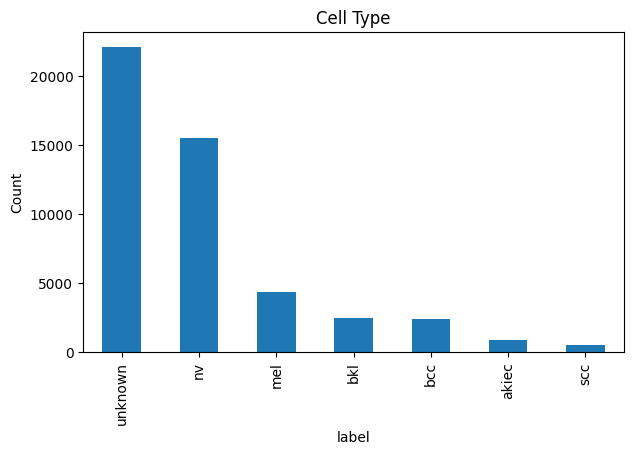

label
6    22117
4    15482
3     4324
2     2469
1     2400
0      878
5      500
Name: count, dtype: int64


In [9]:
fig = plt.figure(figsize=(12, 8))

ax1 = fig.add_subplot(221)
train_df['label'].map(label_to_dx_mapping).value_counts().plot(kind='bar', ax=ax1)
ax1.set_ylabel('Count')
ax1.set_title('Cell Type')

plt.tight_layout()
plt.show()
# Distribution of data into various classes 
print(train_df['label'].value_counts())

41546


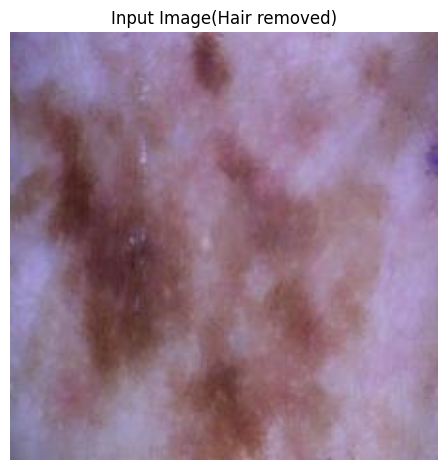

In [10]:
random_index = random.choice(train_df.index)
print(random_index)
input_image = train_df.loc[random_index, 'image_id']
image = np.asarray(Image.open(input_image))
plt.imshow(image)
plt.title('Input Image(Hair removed)')
plt.axis('off')
plt.tight_layout()
plt.show()

In [11]:
from sklearn.utils import class_weight
import numpy as np

# Calculate class weights
class_weights = class_weight.compute_sample_weight(class_weight='balanced',
                                                   y=train_df['label'])

# Create a dictionary mapping class labels to their weights
class_weights_dict = {label: weight for label, weight in zip(train_df['label'], class_weights)}

print(class_weights_dict)

{4: 0.444479303153893, 2: 2.787131863681074, 6: 0.31113752188038934, 5: 13.762857142857143, 1: 2.8672619047619046, 3: 1.5914497158715475, 0: 7.8376179629027005}


Working on index: 0
Working on index: 1000
Working on index: 2000
Working on index: 3000
Working on index: 4000
Working on index: 5000
Working on index: 6000
Working on index: 7000
Working on index: 8000
Working on index: 9000
Working on index: 10000
Working on index: 11000
Working on index: 12000
Working on index: 13000
Working on index: 14000
Working on index: 15000
Working on index: 16000
Working on index: 17000
Working on index: 18000
Working on index: 19000
Working on index: 20000
Working on index: 21000
Working on index: 22000
Working on index: 23000
Working on index: 24000
Working on index: 25000
Working on index: 26000
Working on index: 27000
Working on index: 28000
Working on index: 29000
Working on index: 30000
Working on index: 31000
Working on index: 32000
Working on index: 33000
Working on index: 34000
Working on index: 35000
Working on index: 36000
Working on index: 37000
Working on index: 38000
Working on index: 39000
Working on index: 40000
Working on index: 41000
Worki

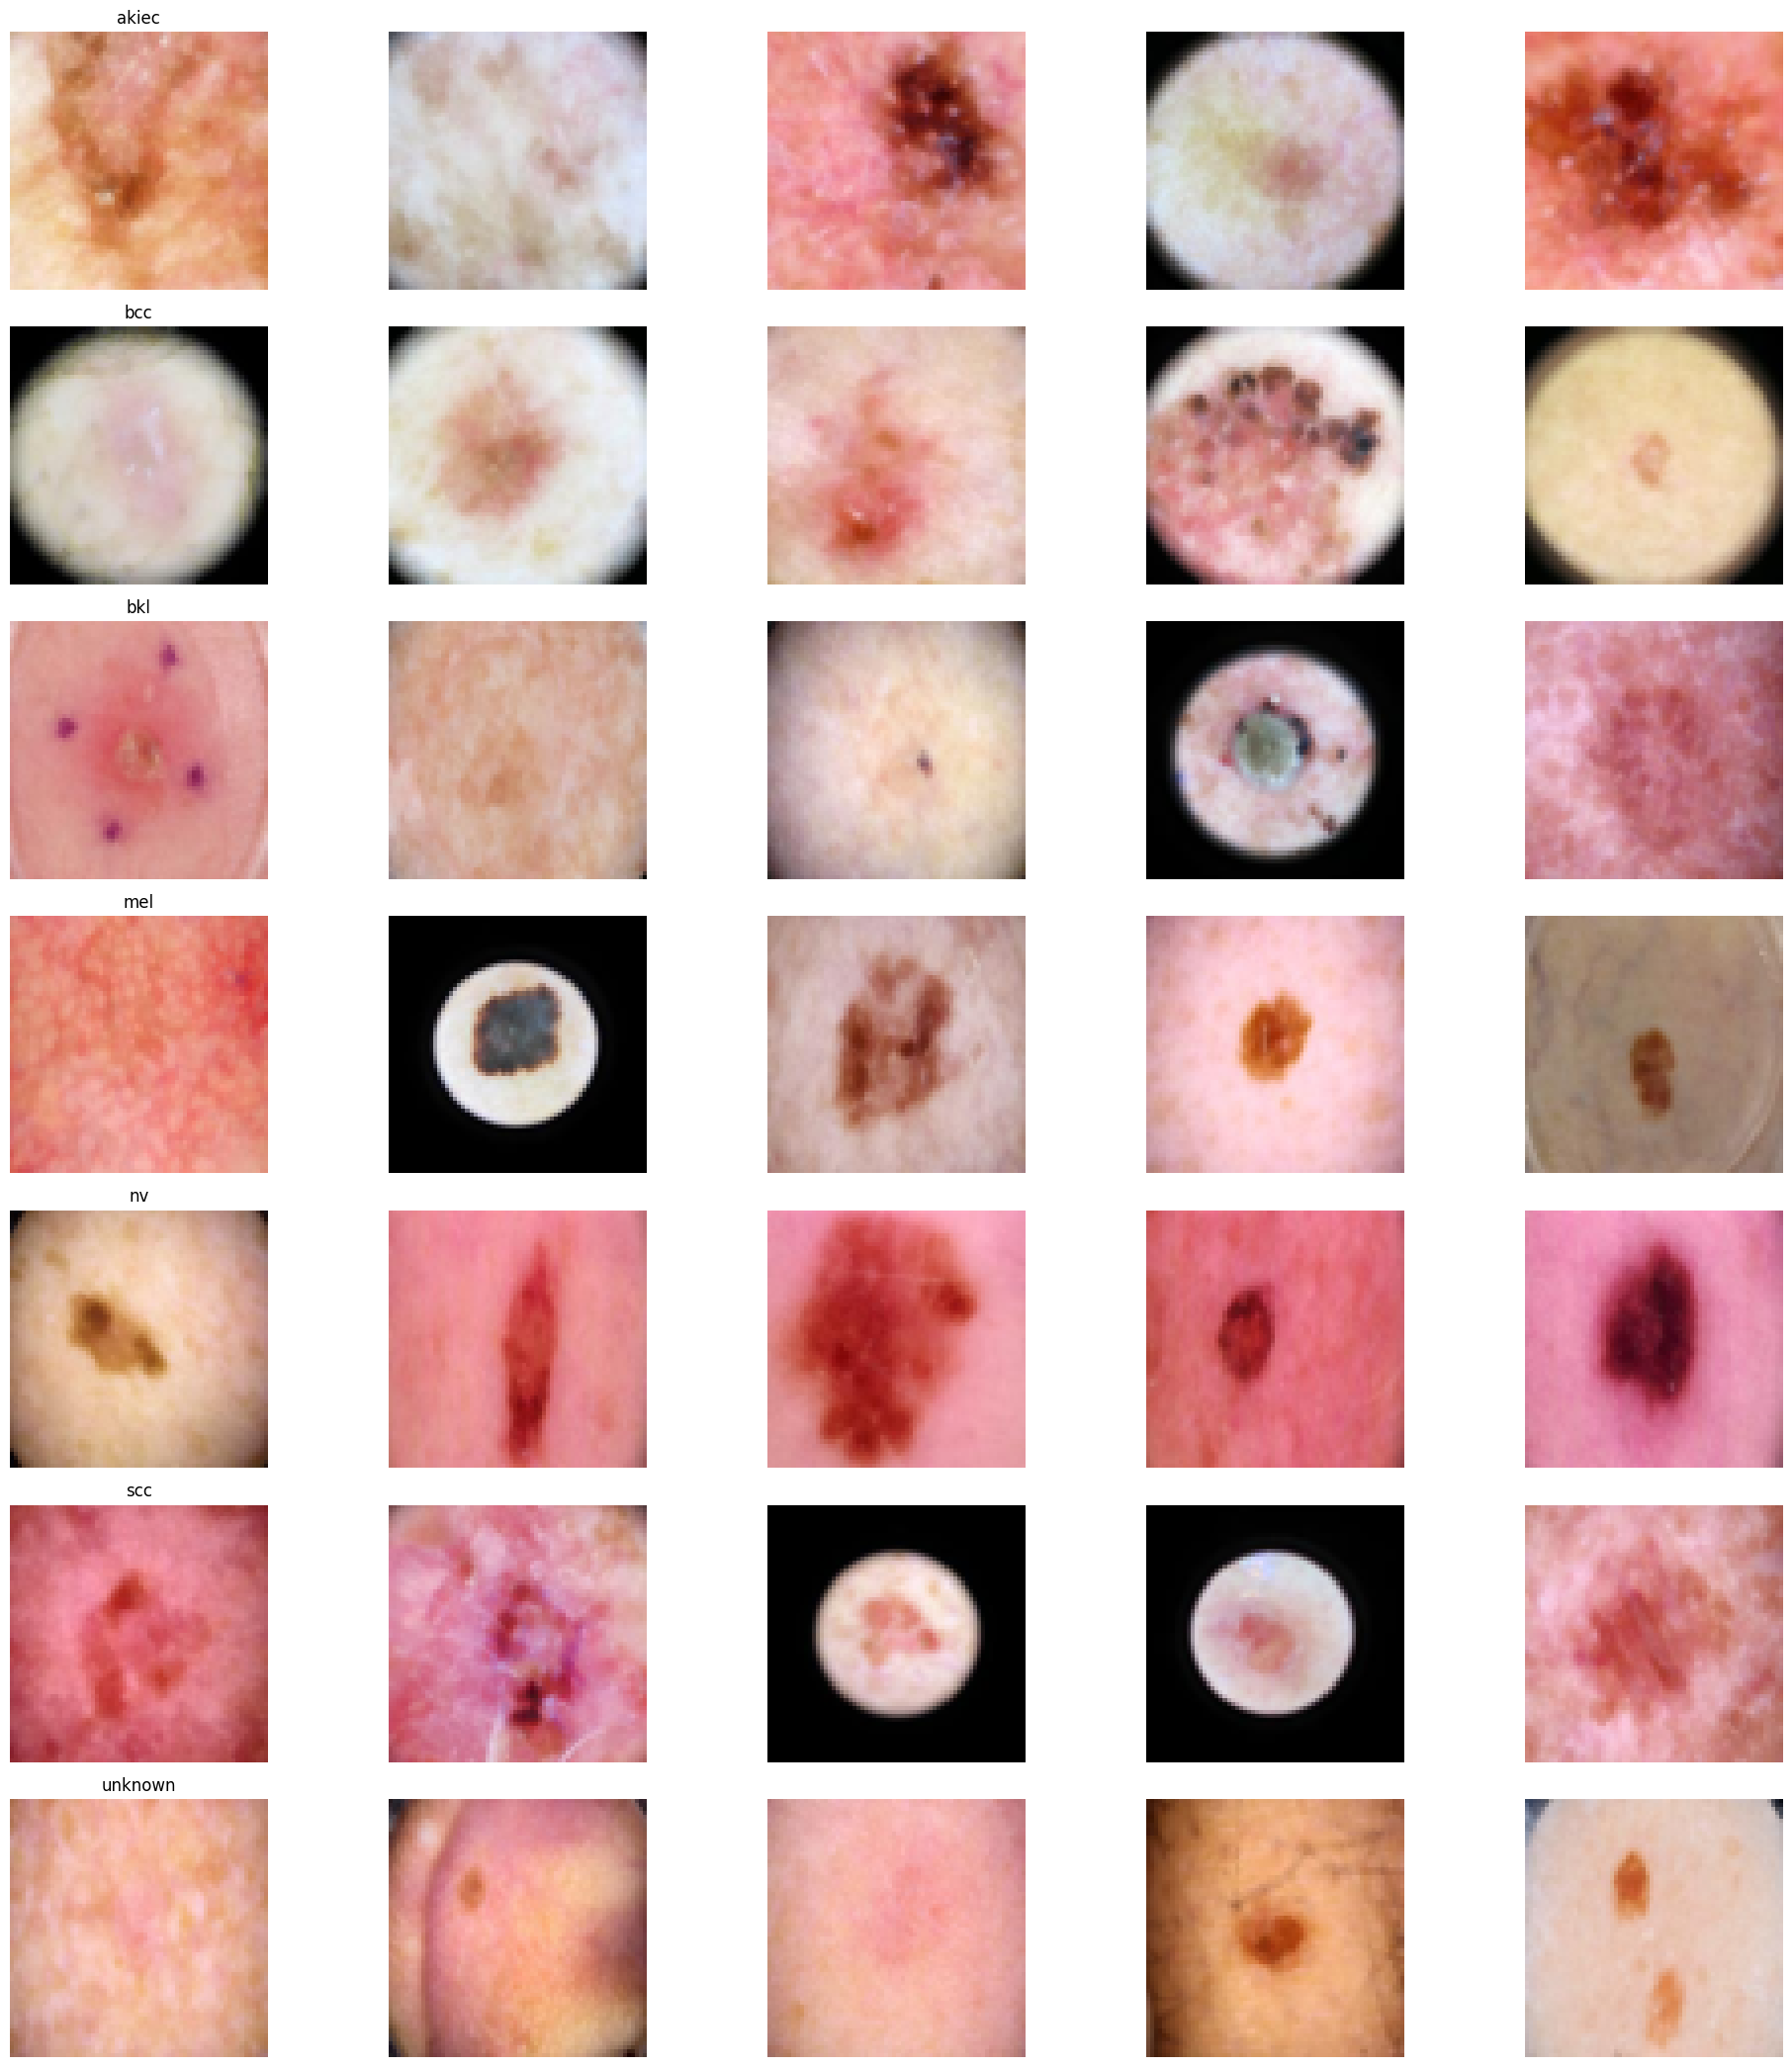

In [12]:
images = []

# Iterate over the DataFrame
for idx, row in train_df.iterrows():
    # Open, resize and convert the image to a numpy array
    image = np.asarray(Image.open(row['image_id']).resize((SIZE, SIZE)))
    # Append the image to the list
    images.append(image)
    
    # Print the current index
    if(idx%1000==0):
        print(f"Working on index: {idx}")
# Drop the 'image_id' column from the DataFrame
train_df.drop('image_id', axis=1, inplace=True)

# Add the list of images as a new column in the DataFrame
train_df['image'] = images

print(train_df)

n_samples = 5  # number of samples for plotting

# Plotting
fig, m_axs = plt.subplots(7, n_samples, figsize=(4 * n_samples, 3 * 7))
for n_axs, (type_name, type_rows) in zip(m_axs, train_df.sort_values(['label']).groupby('label')):
    type_name_dx = label_to_dx_mapping[type_name]  # Map label back to dx
    n_axs[0].set_title(type_name_dx)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')

plt.tight_layout()
plt.show()

label
6    22117
4    15482
3     4324
2     2469
1     2400
0      878
5      500
Name: count, dtype: int64
22117
label
6   -16617
4    -9982
3     1176
2     3031
1     3100
0     4622
5     5000
Name: count, dtype: int64


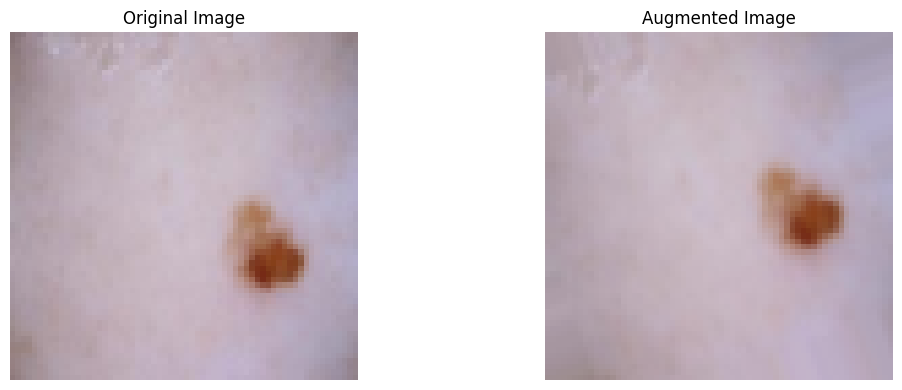

      label                                              image
0         6  [[[190, 139, 138], [194, 143, 142], [201, 150,...
1         3  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...
2         0  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...
3         6  [[[163, 99, 100], [173, 109, 110], [177, 113, ...
4         2  [[[155, 128, 101], [161, 134, 107], [177, 150,...
...     ...                                                ...
65094     5  [[[223, 172, 168], [224, 172, 169], [225, 173,...
65095     5  [[[191, 114, 106], [194, 119, 113], [196, 123,...
65096     1  [[[2, 4, 2], [10, 12, 11], [28, 29, 31], [54, ...
65097     5  [[[1, 1, 1], [1, 1, 1], [0, 0, 0], [0, 0, 0], ...
65098     5  [[[0, 0, 0], [0, 0, 0], [1, 1, 1], [1, 1, 1], ...

[65099 rows x 2 columns]
label
6    22117
4    15482
3     5500
0     5500
2     5500
1     5500
5     5500
Name: count, dtype: int64


In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
counts_per_dx = train_df['label'].value_counts()
max_count = counts_per_dx.max()
augmentation_needed = 5500 - counts_per_dx

print(counts_per_dx)
print(max_count)
print(augmentation_needed)
# Define augmentation sequence
datagen = ImageDataGenerator(
    rotation_range=90,  # Rotate the image by up to 90 degrees
    width_shift_range=0.1,  # Shift the image horizontally by up to 10%
    height_shift_range=0.1,  # Shift the image vertically by up to 10%
    zoom_range=0.05,  # Zoom in on the image by up to 5%
)

random_index = random.choice(train_df.index)

original_img = np.expand_dims(train_df.loc[random_index, 'image'], 0) 
augmented_img = datagen.flow(original_img, batch_size=1)[0].astype(np.uint8)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.imshow(original_img[0])
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(augmented_img[0])
plt.title('Augmented Image')
plt.axis('off')

plt.tight_layout()
plt.show()


def augment_images(df, label, count):
    augmented_images = []  # List to store augmented images
    df_subset = df[df['label'] == label]
    indices = df_subset.index.tolist()
    labels = df_subset['label'].iloc[0]  # Assuming label is same for all images of the same dx
    image_count = len(indices)
    augment_count = count
    if augment_count > 0:
        for i in range(augment_count):
            idx = indices[i % image_count]
            img_rgb = np.expand_dims(df_subset.loc[idx, 'image'], 0)  # Get RGB values from DataFrame and add an extra dimension
            augmented_img_rgb = datagen.flow(img_rgb, batch_size=1)[0].astype(np.uint8)  # Use the datagen.flow() function to apply the augmentations
            augmented_images.append({'label': labels, 'image': augmented_img_rgb[0]})
    return pd.DataFrame(augmented_images)

# Create a new DataFrame to store augmented images
augmented_train_df = pd.DataFrame(columns=train_df.columns)

# Augment images for each dx type
for label, count in augmentation_needed.items():
    if count>0:
        augmented_train_df = pd.concat([augmented_train_df, augment_images(train_df, label, count)], ignore_index=True)

# Combine original and augmented images
augmented_train_df = pd.concat([train_df, augmented_train_df], ignore_index=True)

# Shuffle the dataframe
augmented_train_df = augmented_train_df.sample(frac=1).reset_index(drop=True)

print(augmented_train_df)
print(augmented_train_df['label'].value_counts())
del train_df


In [14]:

df_0 = augmented_train_df[augmented_train_df['label'] == 0]
df_1 = augmented_train_df[augmented_train_df['label'] == 1]
df_2 = augmented_train_df[augmented_train_df['label'] == 2]
df_3 = augmented_train_df[augmented_train_df['label'] == 3]
df_4 = augmented_train_df[augmented_train_df['label'] == 4]
df_5 = augmented_train_df[augmented_train_df['label'] == 5]
df_6 = augmented_train_df[augmented_train_df['label'] == 6]

nsample = 8000

df_0_balanced = resample(df_0, replace=True, n_samples=nsample, random_state=42) 
df_1_balanced = resample(df_1, replace=True, n_samples=nsample, random_state=42) 
df_2_balanced = resample(df_2, replace=True, n_samples=nsample, random_state=42)
df_3_balanced = resample(df_3, replace=True, n_samples=nsample, random_state=42)
df_5_balanced = resample(df_5, replace=True, n_samples=nsample, random_state=42)

skin_df_balanced = pd.concat([df_0_balanced, df_1_balanced, 
                              df_2_balanced, df_3_balanced, 
                              df_4, df_5_balanced, df_6])

skin_df_balanced = skin_df_balanced.sample(frac=1).reset_index(drop=True)

print(skin_df_balanced['label'].value_counts())
print(skin_df_balanced)

del df_0
del df_1
del df_2
del df_3
del df_4
del df_5
del df_6
del df_0_balanced
del df_1_balanced
del df_2_balanced
del df_3_balanced
del df_5_balanced
del augmented_train_df

label
6    22117
4    15482
5     8000
3     8000
0     8000
1     8000
2     8000
Name: count, dtype: int64
      label                                              image
0         5  [[[229, 142, 140], [228, 145, 142], [228, 148,...
1         0  [[[231, 163, 154], [228, 159, 150], [232, 164,...
2         3  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...
3         6  [[[154, 87, 59], [159, 92, 64], [170, 103, 75]...
4         6  [[[172, 121, 164], [170, 119, 160], [175, 125,...
...     ...                                                ...
77594     4  [[[218, 138, 151], [224, 142, 154], [225, 143,...
77595     4  [[[186, 153, 133], [190, 166, 154], [198, 177,...
77596     4  [[[188, 174, 192], [193, 178, 196], [193, 179,...
77597     2  [[[146, 116, 120], [147, 116, 121], [145, 114,...
77598     2  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...

[77599 rows x 2 columns]


Number of pictures for each class in test folder
dx
nv         1340
mel         222
bkl         221
bcc         103
akiec        65
unknown      52
Name: count, dtype: int64
                                               image_id   dx
0     /kaggle/input/hair-removed-knowledge-base/Know...   nv
1     /kaggle/input/hair-removed-knowledge-base/Know...   nv
2     /kaggle/input/hair-removed-knowledge-base/Know...   nv
3     /kaggle/input/hair-removed-knowledge-base/Know...   nv
4     /kaggle/input/hair-removed-knowledge-base/Know...   nv
...                                                 ...  ...
1998  /kaggle/input/hair-removed-knowledge-base/Know...  mel
1999  /kaggle/input/hair-removed-knowledge-base/Know...   nv
2000  /kaggle/input/hair-removed-knowledge-base/Know...   nv
2001  /kaggle/input/hair-removed-knowledge-base/Know...  mel
2002  /kaggle/input/hair-removed-knowledge-base/Know...   nv

[2003 rows x 2 columns]
                                               image_id  label
953   

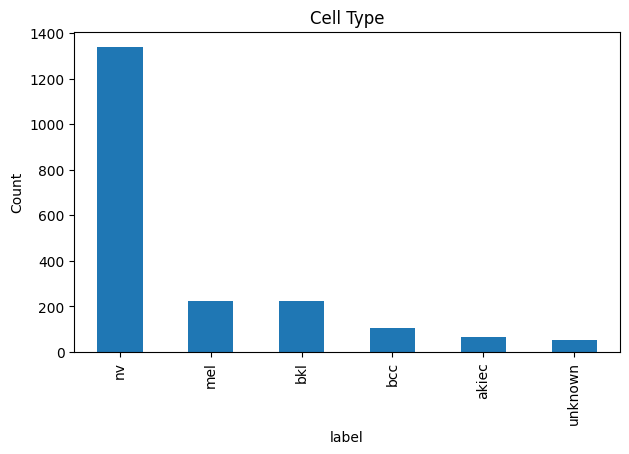

label
4    1340
3     222
2     221
1     103
0      65
6      52
Name: count, dtype: int64
Working on index: 0
Working on index: 100
Working on index: 200
Working on index: 300
Working on index: 400
Working on index: 500
Working on index: 600
Working on index: 700
Working on index: 800
Working on index: 900
Working on index: 1000
Working on index: 1100
Working on index: 1200
Working on index: 1300
Working on index: 1400
Working on index: 1500
Working on index: 1600
Working on index: 1700
Working on index: 1800
Working on index: 1900
Working on index: 2000
      label                                              image
0         4  [[[166, 136, 164], [170, 141, 169], [174, 147,...
1         4  [[[245, 224, 229], [241, 220, 225], [244, 223,...
2         4  [[[170, 167, 188], [181, 177, 199], [183, 177,...
3         4  [[[169, 120, 116], [171, 122, 118], [174, 125,...
4         4  [[[251, 156, 162], [254, 159, 163], [255, 160,...
...     ...                                                

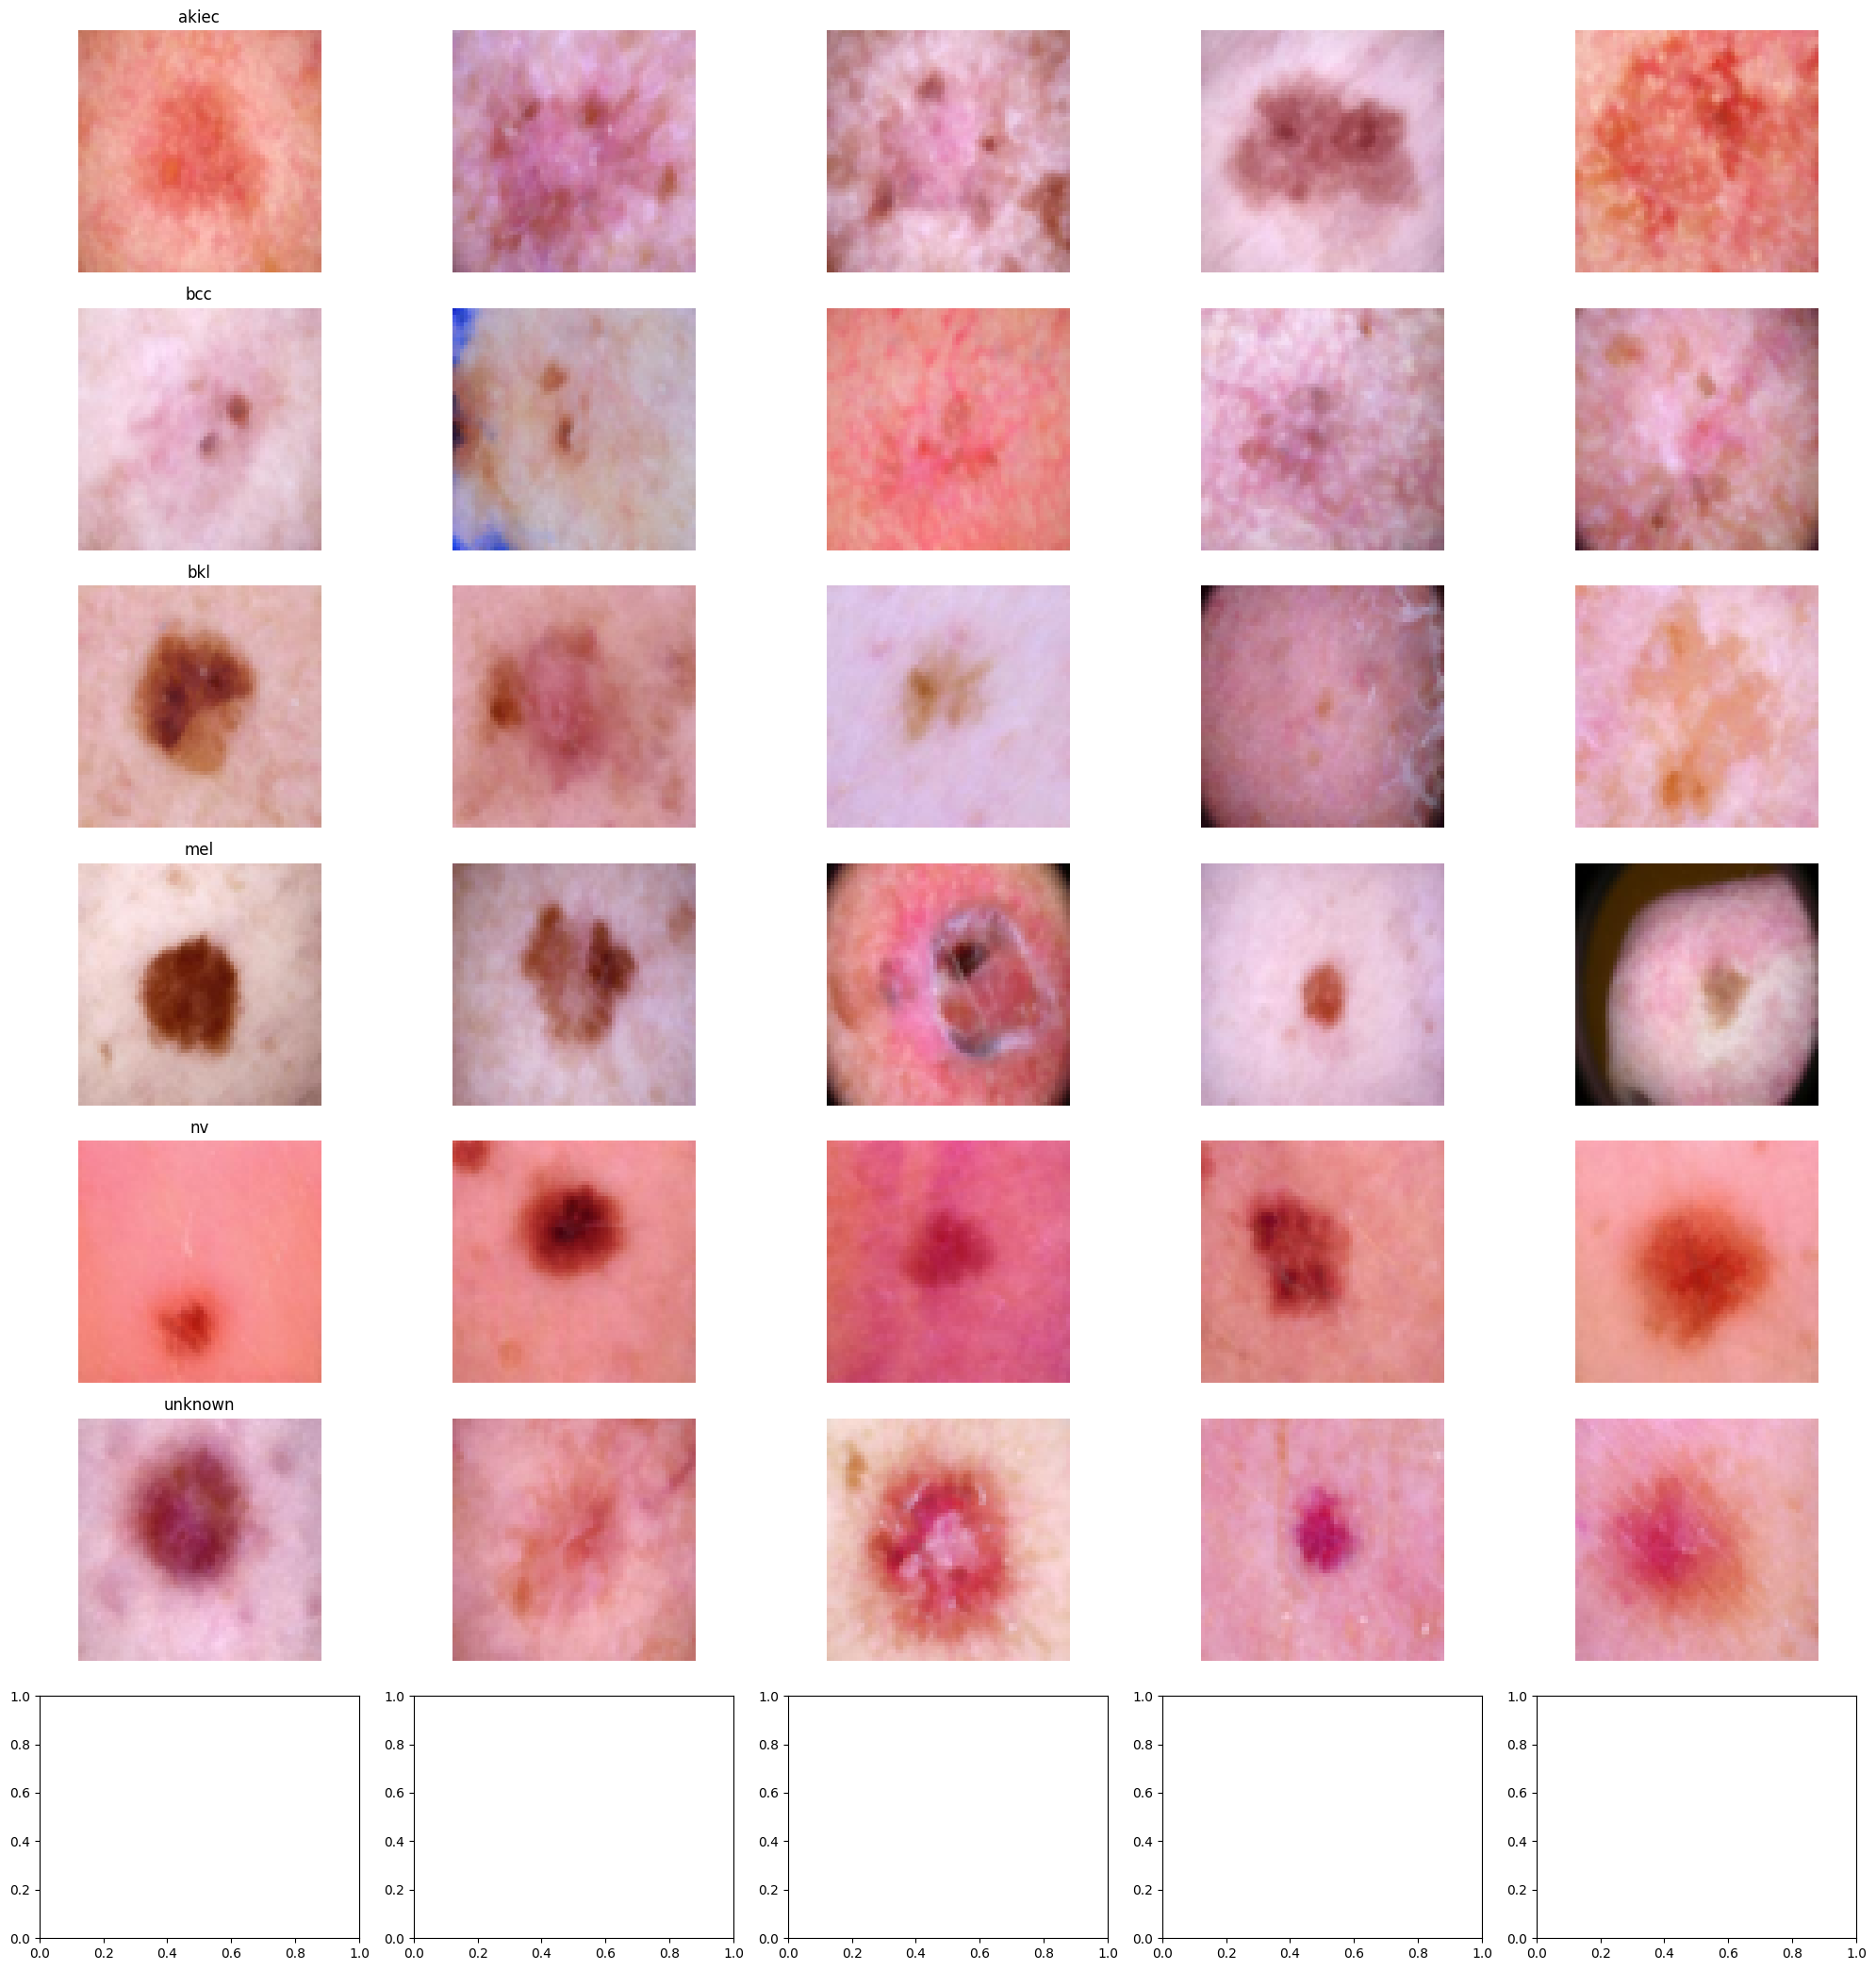

In [15]:
test_dir = '/kaggle/input/hair-removed-knowledge-base/KnowledgeBase/test/ham10000'
test_metadata = []
for disease in ['akiec', 'bcc', 'bkl', 'mel', 'nv', 'unknown']:
    test_images = os.listdir(os.path.join(test_dir, disease))
    test_metadata.extend([(os.path.join(test_dir, disease, image), disease) for image in test_images])
test_df1 = pd.DataFrame(test_metadata, columns=['image_id', 'dx'])
print("Number of pictures for each class in test folder")
print(test_df1['dx'].value_counts())
test_df1 = test_df1.sample(frac=1).reset_index(drop=True)
print(test_df1)
del test_metadata

# Now you can transform the labels in your dataframe
test_df1['label'] = le.transform(test_df1['dx'])
test_df1.drop('dx', axis=1, inplace=True)
print(test_df1.sample(10))
fig = plt.figure(figsize=(12, 8))

ax1 = fig.add_subplot(221)
test_df1['label'].map(label_to_dx_mapping).value_counts().plot(kind='bar', ax=ax1)
ax1.set_ylabel('Count')
ax1.set_title('Cell Type')

plt.tight_layout()
plt.show()
print(test_df1['label'].value_counts())
images = []

# Iterate over the DataFrame
for idx, row in test_df1.iterrows():
    # Open, resize and convert the image to a numpy array
    image = np.asarray(Image.open(row['image_id']).resize((SIZE, SIZE)))
    # Append the image to the list
    images.append(image)
    
    # Print the current index
    if(idx%100==0):
        print(f"Working on index: {idx}")
# Drop the 'image_id' column from the DataFrame
test_df1.drop('image_id', axis=1, inplace=True)

# Add the list of images as a new column in the DataFrame
test_df1['image'] = images

print(test_df1)

n_samples = 5  # number of samples for plotting

# Plotting
fig, m_axs = plt.subplots(7, n_samples, figsize=(4 * n_samples, 3 * 7))
for n_axs, (type_name, type_rows) in zip(m_axs, test_df1.sort_values(['label']).groupby('label')):
    type_name_dx = label_to_dx_mapping[type_name]  # Map label back to dx
    n_axs[0].set_title(type_name_dx)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')

plt.tight_layout()
plt.show()

Number of pictures for each class in test folder
dx
unknown    5447
nv         1030
mel         105
bkl          44
Name: count, dtype: int64
                                               image_id       dx
0     /kaggle/input/hair-removed-knowledge-base/Know...  unknown
1     /kaggle/input/hair-removed-knowledge-base/Know...  unknown
2     /kaggle/input/hair-removed-knowledge-base/Know...  unknown
3     /kaggle/input/hair-removed-knowledge-base/Know...       nv
4     /kaggle/input/hair-removed-knowledge-base/Know...  unknown
...                                                 ...      ...
6621  /kaggle/input/hair-removed-knowledge-base/Know...  unknown
6622  /kaggle/input/hair-removed-knowledge-base/Know...  unknown
6623  /kaggle/input/hair-removed-knowledge-base/Know...  unknown
6624  /kaggle/input/hair-removed-knowledge-base/Know...  unknown
6625  /kaggle/input/hair-removed-knowledge-base/Know...  unknown

[6626 rows x 2 columns]
['akiec', 'bcc', 'bkl', 'mel', 'nv', 'scc', 'unknown'

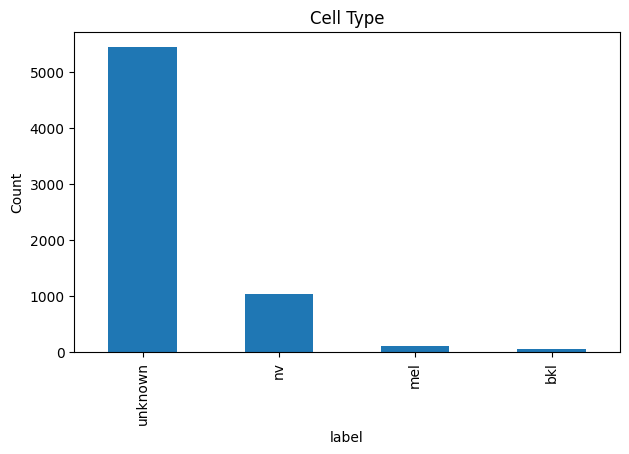

label
6    5447
4    1030
3     105
2      44
Name: count, dtype: int64
Working on index: 0
Working on index: 100
Working on index: 200
Working on index: 300
Working on index: 400
Working on index: 500
Working on index: 600
Working on index: 700
Working on index: 800
Working on index: 900
Working on index: 1000
Working on index: 1100
Working on index: 1200
Working on index: 1300
Working on index: 1400
Working on index: 1500
Working on index: 1600
Working on index: 1700
Working on index: 1800
Working on index: 1900
Working on index: 2000
Working on index: 2100
Working on index: 2200
Working on index: 2300
Working on index: 2400
Working on index: 2500
Working on index: 2600
Working on index: 2700
Working on index: 2800
Working on index: 2900
Working on index: 3000
Working on index: 3100
Working on index: 3200
Working on index: 3300
Working on index: 3400
Working on index: 3500
Working on index: 3600
Working on index: 3700
Working on index: 3800
Working on index: 3900
Working on index: 40

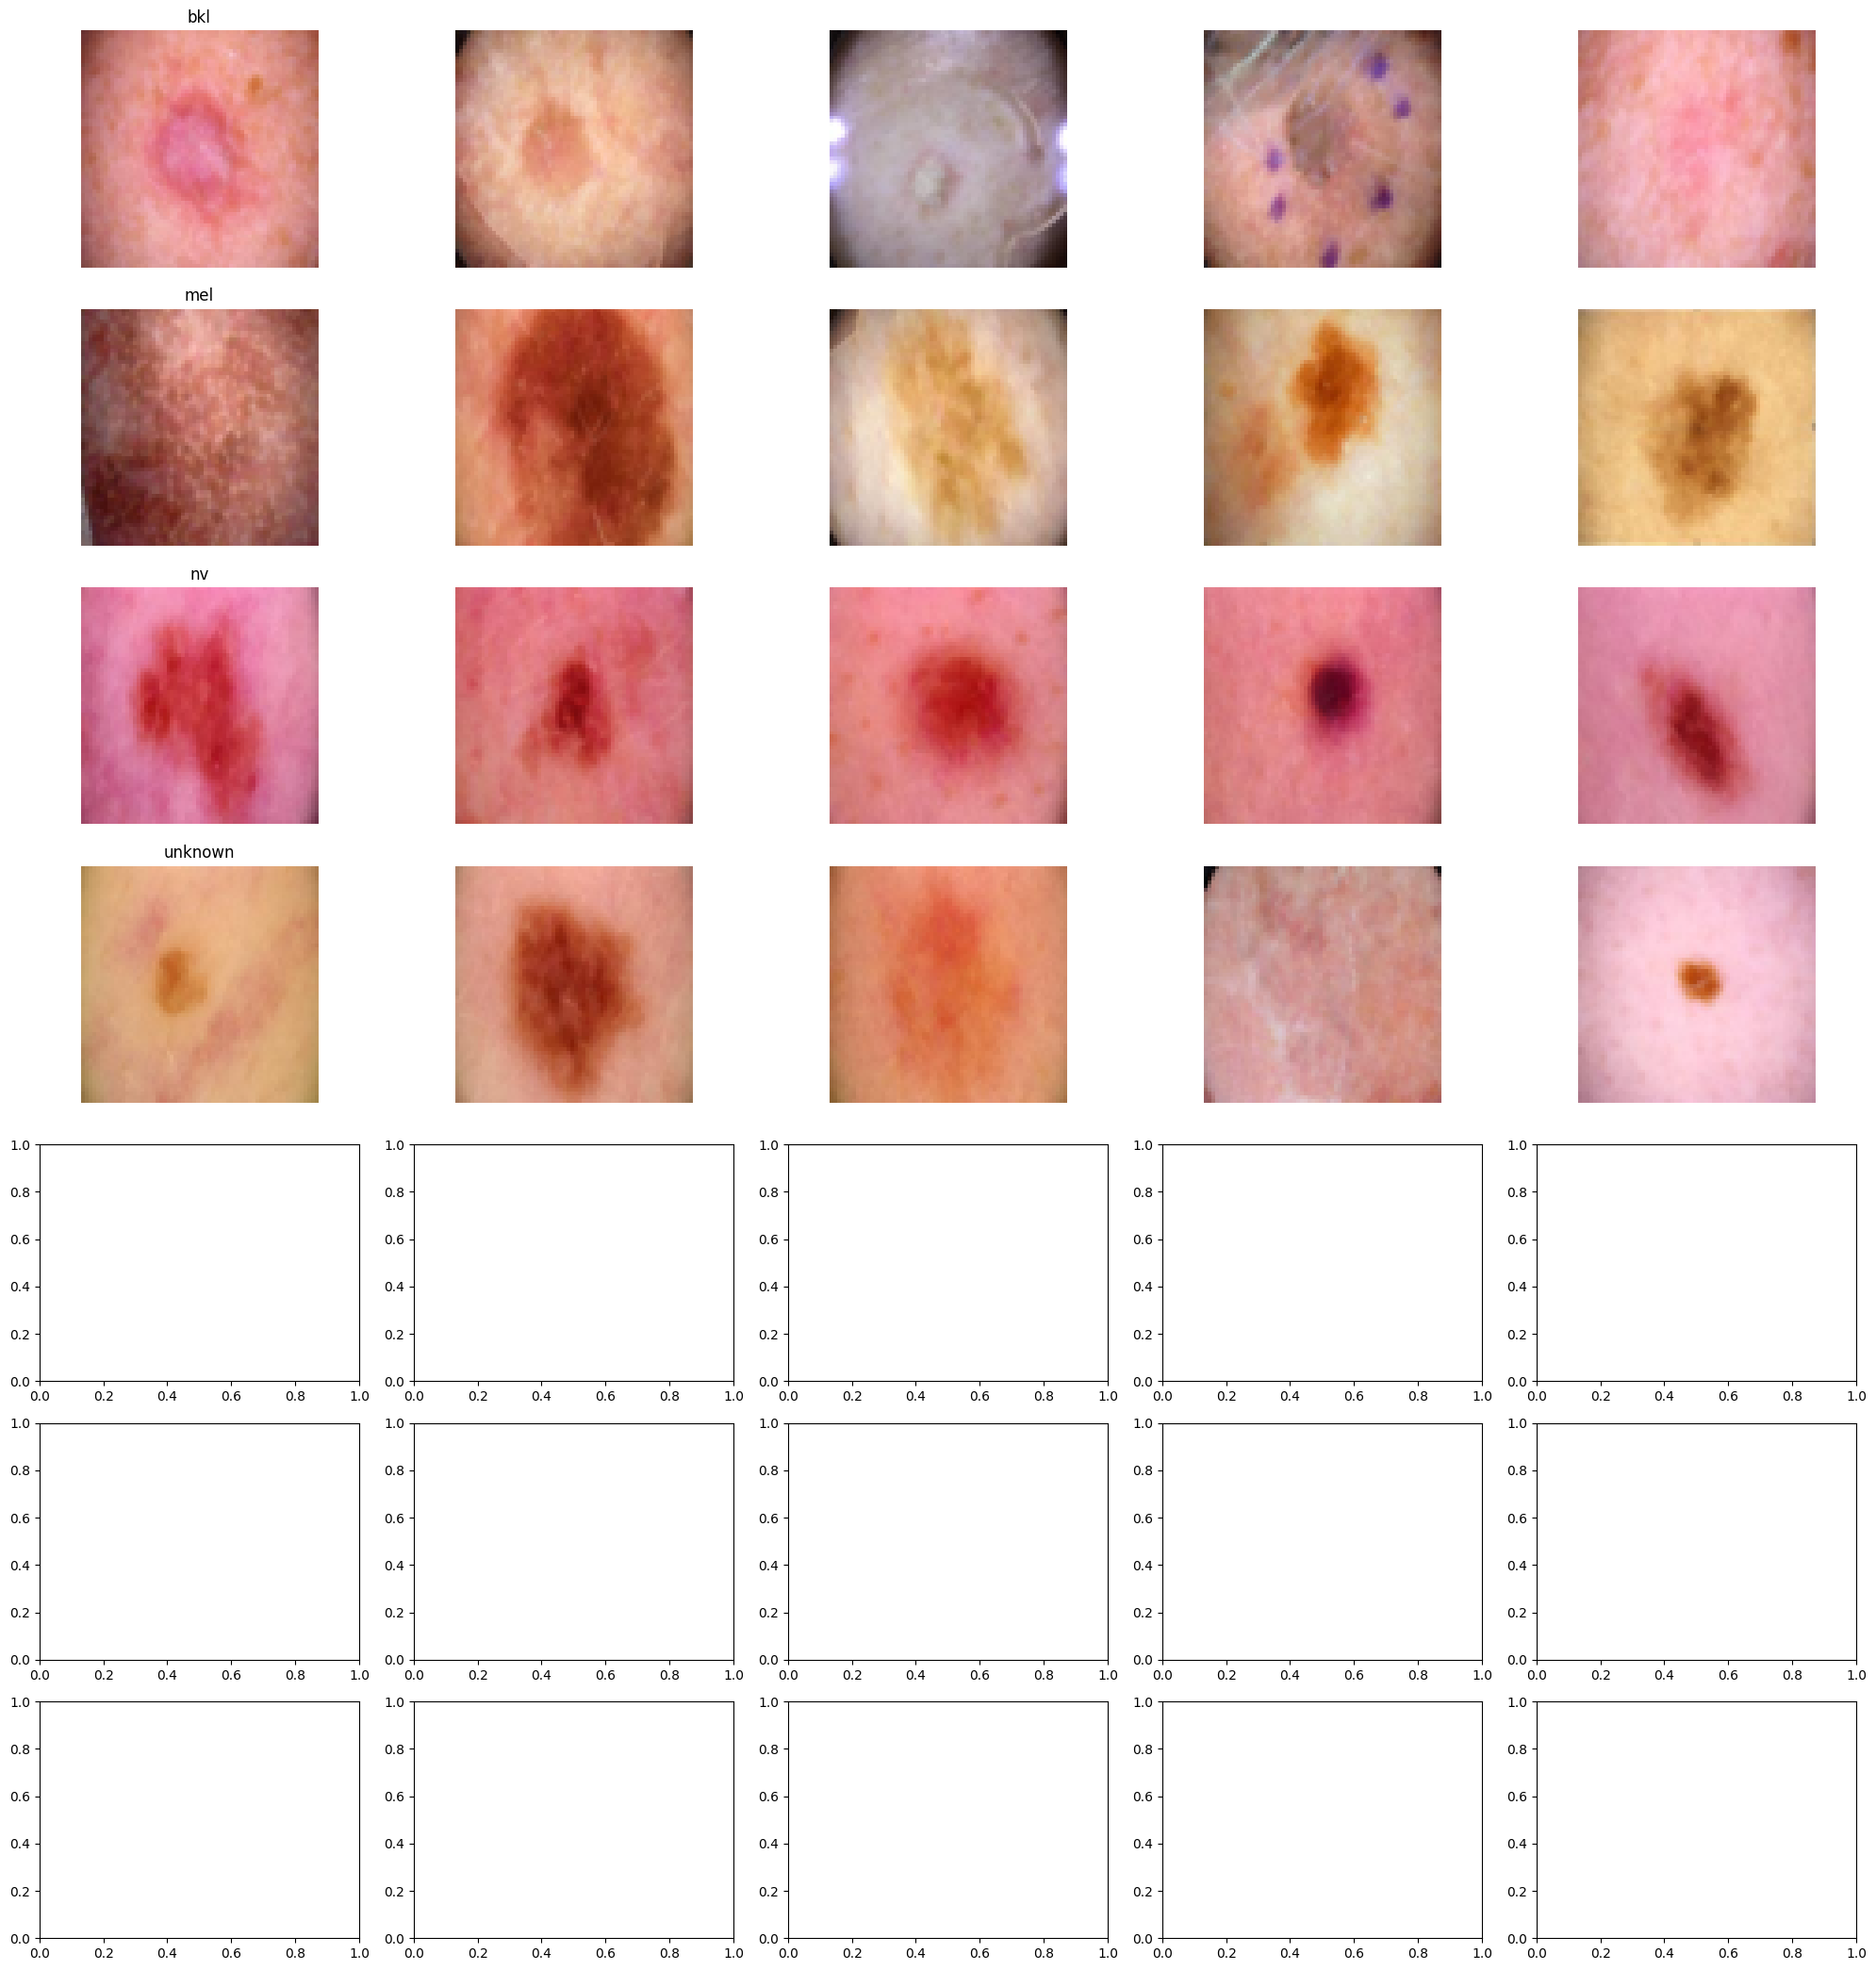

In [16]:
test_dir = '/kaggle/input/hair-removed-knowledge-base/KnowledgeBase/test/2020'
test_metadata = []
for disease in ['bkl', 'mel', 'nv', 'unknown']:
    test_images = os.listdir(os.path.join(test_dir, disease))
    test_metadata.extend([(os.path.join(test_dir, disease, image), disease) for image in test_images])
test_df2 = pd.DataFrame(test_metadata, columns=['image_id', 'dx'])
print("Number of pictures for each class in test folder")
print(test_df2['dx'].value_counts())
test_df2 = test_df2.sample(frac=1).reset_index(drop=True)
print(test_df2)
del test_metadata
# Now you can transform the labels in your datafram
test_df2['label'] = le.transform(test_df2['dx'])
print(list(le.classes_))
test_df2.drop('dx', axis=1, inplace=True)
print(test_df2.sample(10))
fig = plt.figure(figsize=(12, 8))

ax1 = fig.add_subplot(221)
test_df2['label'].map(label_to_dx_mapping).value_counts().plot(kind='bar', ax=ax1)
ax1.set_ylabel('Count')
ax1.set_title('Cell Type')

plt.tight_layout()
plt.show()
print(test_df2['label'].value_counts())
images = []

# Iterate over the DataFrame
for idx, row in test_df2.iterrows():
    # Open, resize and convert the image to a numpy array
    image = np.asarray(Image.open(row['image_id']).resize((SIZE, SIZE)))
    # Append the image to the list
    images.append(image)
    
    # Print the current index
    if(idx%100==0):
        print(f"Working on index: {idx}")
# Drop the 'image_id' column from the DataFrame
test_df2.drop('image_id', axis=1, inplace=True)

# Add the list of images as a new column in the DataFrame
test_df2['image'] = images

print(test_df2)

n_samples = 5  # number of samples for plotting

# Plotting
fig, m_axs = plt.subplots(7, n_samples, figsize=(4 * n_samples, 3 * 7))
for n_axs, (type_name, type_rows) in zip(m_axs, test_df2.sort_values(['label']).groupby('label')):
    type_name_dx = label_to_dx_mapping[type_name]  # Map label back to dx
    n_axs[0].set_title(type_name_dx)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')

plt.tight_layout()
plt.show()

Number of pictures for each class in test folder
dx
nv         2622
mel         857
bcc         695
bkl         508
akiec       164
scc         128
unknown      93
Name: count, dtype: int64
                                               image_id   dx
0     /kaggle/input/hair-removed-knowledge-base/Know...  bcc
1     /kaggle/input/hair-removed-knowledge-base/Know...  mel
2     /kaggle/input/hair-removed-knowledge-base/Know...   nv
3     /kaggle/input/hair-removed-knowledge-base/Know...   nv
4     /kaggle/input/hair-removed-knowledge-base/Know...   nv
...                                                 ...  ...
5062  /kaggle/input/hair-removed-knowledge-base/Know...  bcc
5063  /kaggle/input/hair-removed-knowledge-base/Know...  bkl
5064  /kaggle/input/hair-removed-knowledge-base/Know...  bcc
5065  /kaggle/input/hair-removed-knowledge-base/Know...   nv
5066  /kaggle/input/hair-removed-knowledge-base/Know...   nv

[5067 rows x 2 columns]
                                               image_

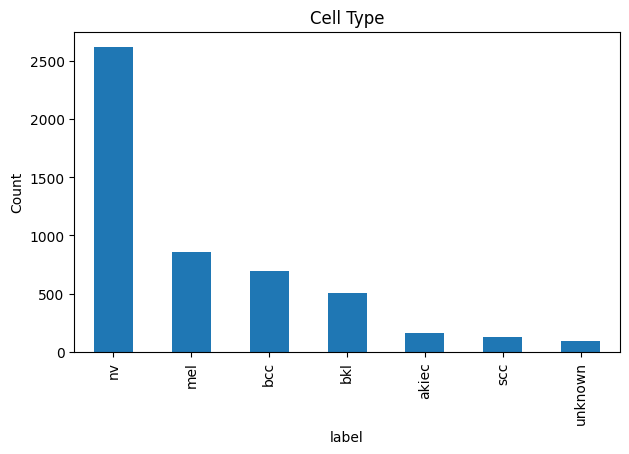

label
4    2622
3     857
1     695
2     508
0     164
5     128
6      93
Name: count, dtype: int64
Working on index: 0
Working on index: 100
Working on index: 200
Working on index: 300
Working on index: 400
Working on index: 500
Working on index: 600
Working on index: 700
Working on index: 800
Working on index: 900
Working on index: 1000
Working on index: 1100
Working on index: 1200
Working on index: 1300
Working on index: 1400
Working on index: 1500
Working on index: 1600
Working on index: 1700
Working on index: 1800
Working on index: 1900
Working on index: 2000
Working on index: 2100
Working on index: 2200
Working on index: 2300
Working on index: 2400
Working on index: 2500
Working on index: 2600
Working on index: 2700
Working on index: 2800
Working on index: 2900
Working on index: 3000
Working on index: 3100
Working on index: 3200
Working on index: 3300
Working on index: 3400
Working on index: 3500
Working on index: 3600
Working on index: 3700
Working on index: 3800
Working on in

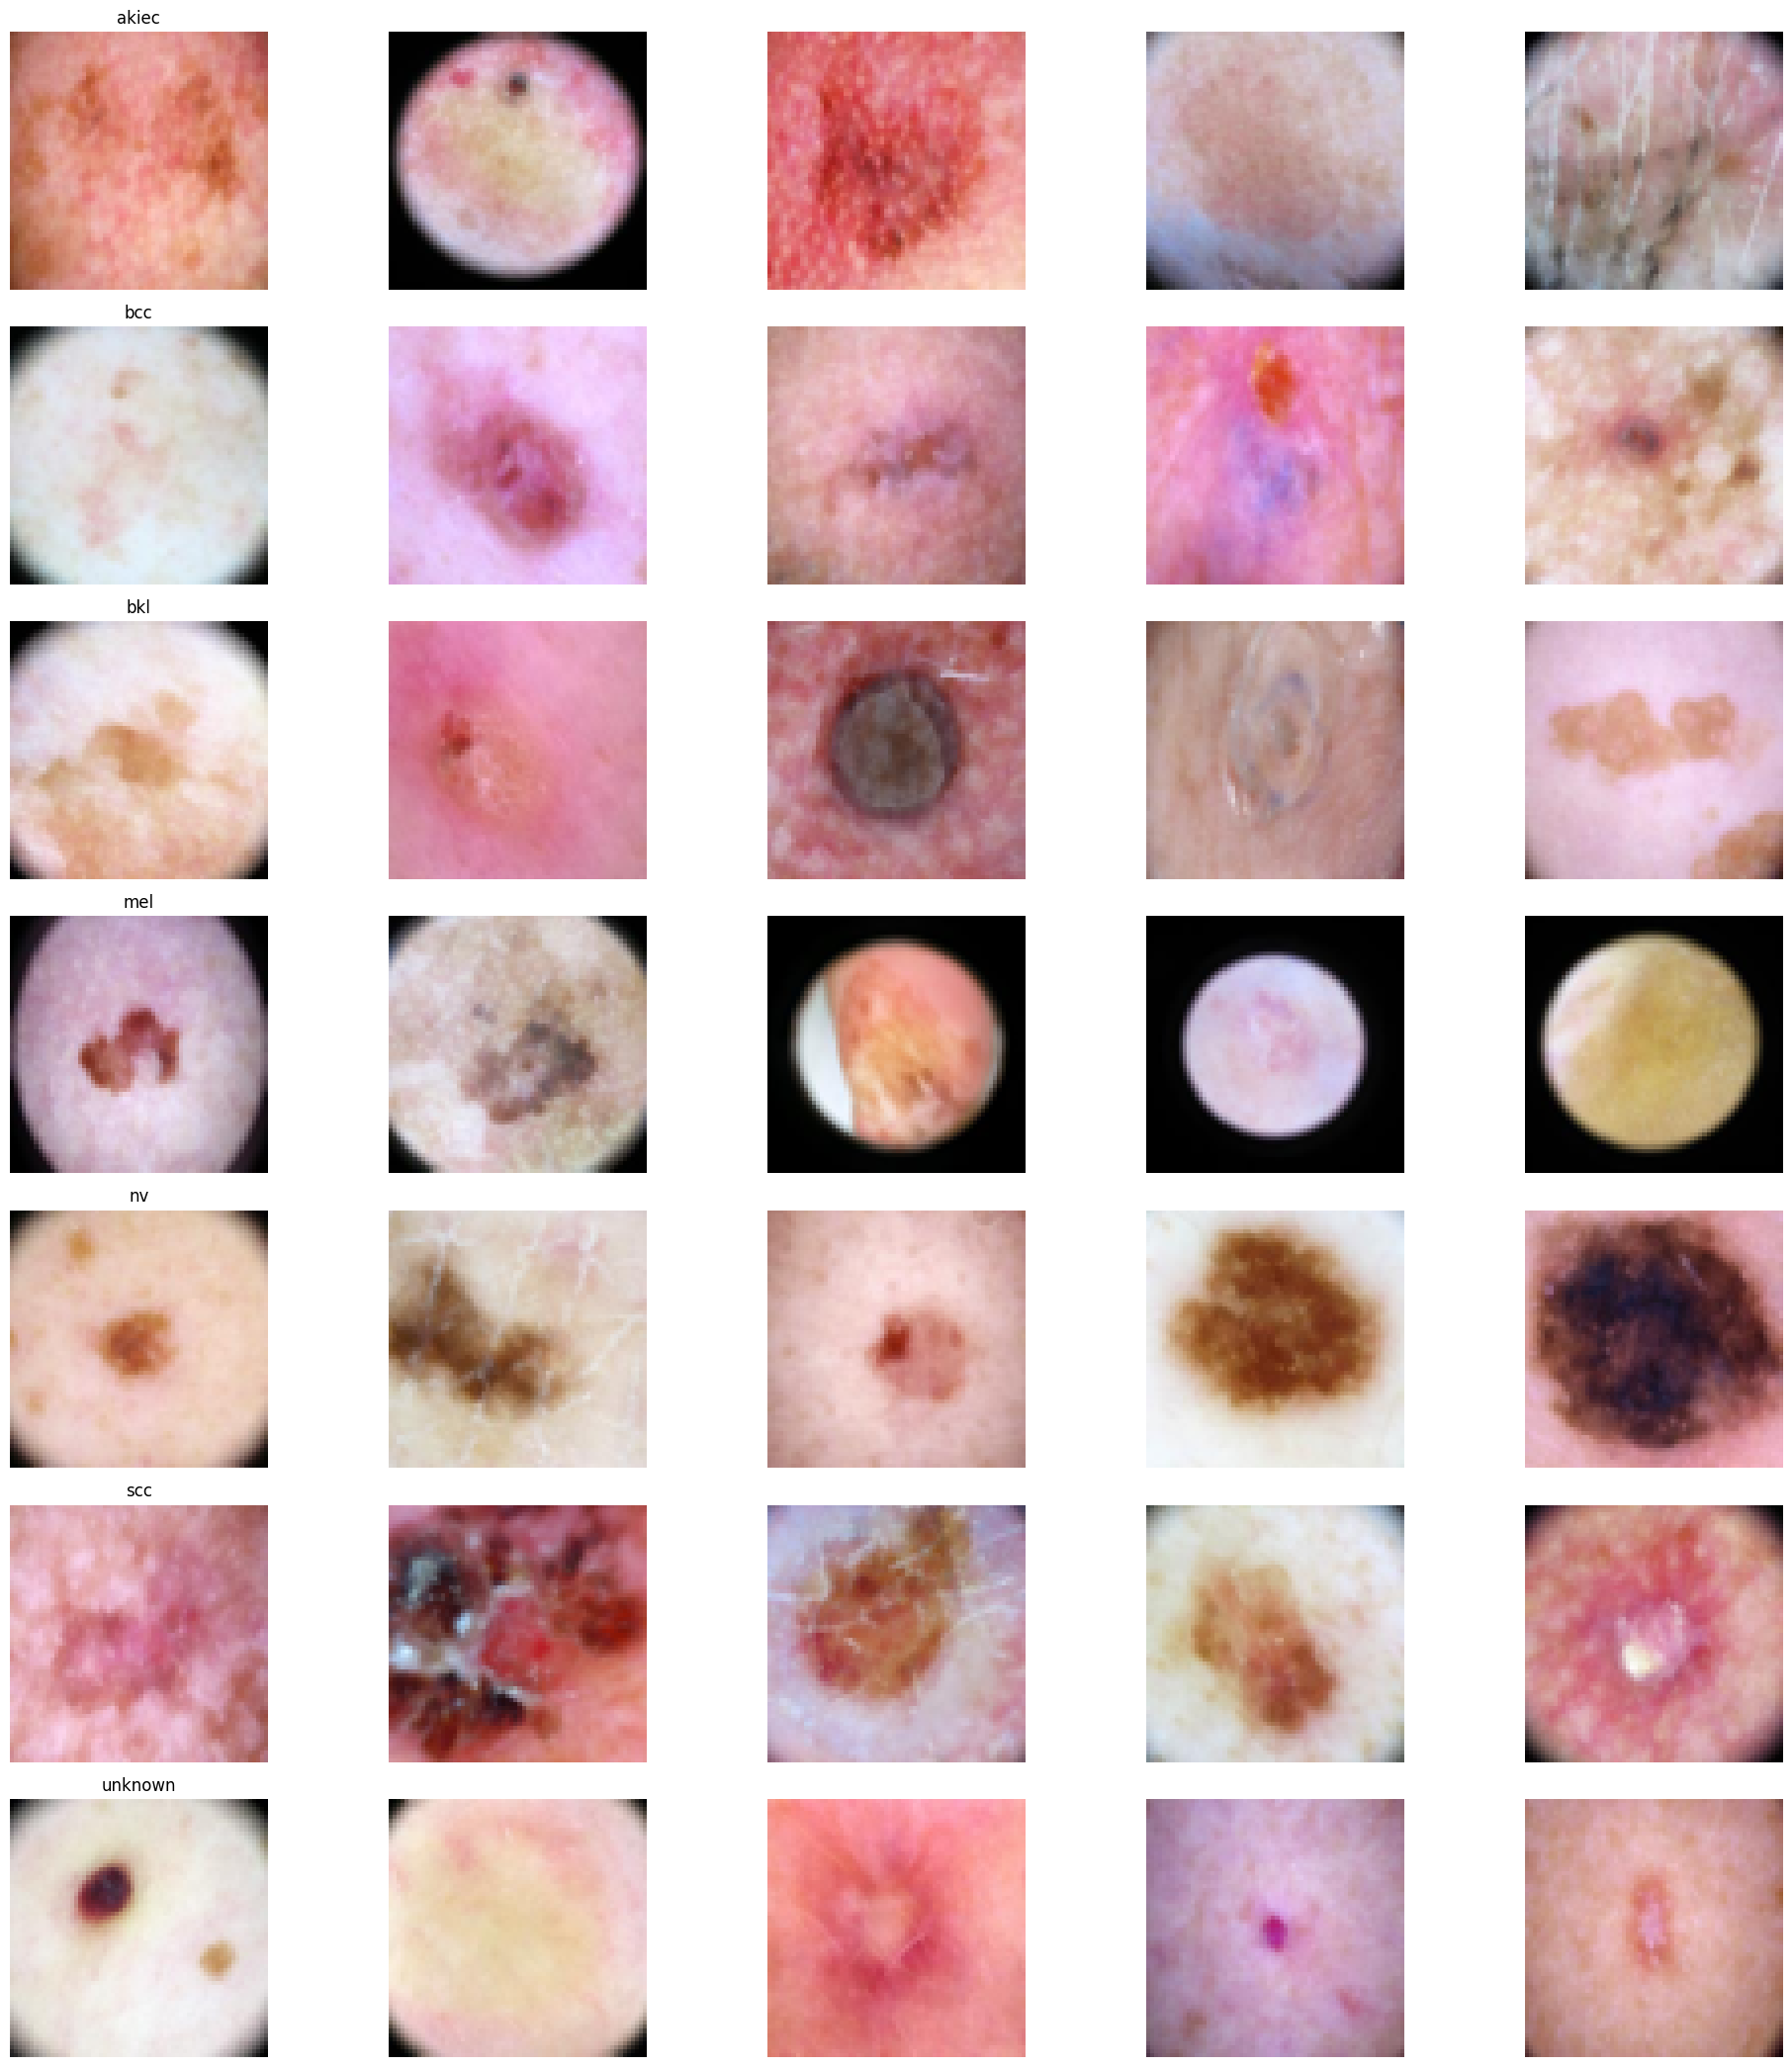

In [17]:
test_dir = '/kaggle/input/hair-removed-knowledge-base/KnowledgeBase/test/2019'
test_metadata = []
for disease in ['akiec', 'bcc', 'bkl', 'mel', 'nv', 'scc', 'unknown']:
    test_images = os.listdir(os.path.join(test_dir, disease))
    test_metadata.extend([(os.path.join(test_dir, disease, image), disease) for image in test_images])
test_df3 = pd.DataFrame(test_metadata, columns=['image_id', 'dx'])
print("Number of pictures for each class in test folder")
print(test_df3['dx'].value_counts())
test_df3 = test_df3.sample(frac=1).reset_index(drop=True)
print(test_df3)
del test_metadata

test_df3['label'] = le.transform(test_df3["dx"]) 
del le
test_df3.drop('dx', axis=1, inplace=True)
print(test_df3.sample(10))
fig = plt.figure(figsize=(12, 8))

ax1 = fig.add_subplot(221)
test_df3['label'].map(label_to_dx_mapping).value_counts().plot(kind='bar', ax=ax1)
ax1.set_ylabel('Count')
ax1.set_title('Cell Type')

plt.tight_layout()
plt.show()
print(test_df3['label'].value_counts())
images = []

# Iterate over the DataFrame
for idx, row in test_df3.iterrows():
    # Open, resize and convert the image to a numpy array
    image = np.asarray(Image.open(row['image_id']).resize((SIZE, SIZE)))
    # Append the image to the list
    images.append(image)
    
    # Print the current index
    if(idx%100==0):
        print(f"Working on index: {idx}")
# Drop the 'image_id' column from the DataFrame
test_df3.drop('image_id', axis=1, inplace=True)

# Add the list of images as a new column in the DataFrame
test_df3['image'] = images

print(test_df3)

n_samples = 5  # number of samples for plotting

# Plotting
fig, m_axs = plt.subplots(7, n_samples, figsize=(4 * n_samples, 3 * 7))
for n_axs, (type_name, type_rows) in zip(m_axs, test_df3.sort_values(['label']).groupby('label')):
    type_name_dx = label_to_dx_mapping[type_name]  # Map label back to dx
    n_axs[0].set_title(type_name_dx)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')

plt.tight_layout()
plt.show()

In [18]:
test_df = pd.concat([test_df1, test_df2, test_df3])

In [19]:
x_train = np.asarray(skin_df_balanced['image'].tolist())
x_train = x_train/255.
Y=skin_df_balanced['label']
y_train = to_categorical(Y, num_classes=7)

In [20]:
del skin_df_balanced
del Y
del test_df1
del test_df2
del test_df3

In [21]:
x_test = np.asarray(test_df['image'].tolist())
x_test = x_test/255.
Y=test_df['label']
y_test = to_categorical(Y, num_classes=7)
del test_df
del Y

In [22]:
num_classes = 7

pretrained_efficientnet = EfficientNetV2M(weights='imagenet', include_top=False, input_shape = (SIZE, SIZE, 3), include_preprocessing=False)

x = pretrained_efficientnet.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=pretrained_efficientnet.input, outputs=predictions)

pretrained_efficientnet.trainable = True
# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-3), metrics=['accuracy'])

model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 32, 32,    │        648 │ input_layer_3[0]… │
│                     │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 32, 32,    │         96 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 32, 32,    │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 32, 32,    │      5,184 │ stem_activation[… │
│ (Conv2D)            │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 32, 32,    │         96 │ block1a_project_… │
│ (BatchNormalizatio… │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, 32, 32,    │          0 │ block1a_project_… │
│ (Activation)        │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_add (Add)   │ (None, 32, 32,    │          0 │ block1a_project_… │
│                     │ 24)               │            │ stem_activation[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_co… │ (None, 32, 32,    │      5,184 │ block1a_add[0][0] │
│ (Conv2D)            │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_bn  │ (None, 32, 32,    │         96 │ block1b_project_… │
│ (BatchNormalizatio… │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_ac… │ (None, 32, 32,    │          0 │ block1b_project_… │
│ (Activation)        │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_drop        │ (None, 32, 32,    │          0 │ block1b_project_… │
│ (Dropout)           │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_add (Add)   │ (None, 32, 32,    │          0 │ block1b_drop[0][… │
│                     │ 24)               │            │ block1a_add[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1c_project_co… │ (None, 32, 32,    │      5,184 │ block1b_add[0][0] │
│ (Conv2D)            │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1c_project_bn  │ (None, 32, 32,    │         96 │ block1c_project_… │
│ (BatchNormalizatio… │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1c_project_ac… │ (None, 32, 32,    │          0 │ block1c_project_… │
│ (Activation)        │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1c_drop        │ (None, 32, 32,    │          0 │ block1c_project_

 Total params: 54,502,971 (207.91 MB)

 Trainable params: 54,210,939 (206.80 MB)

 Non-trainable params: 292,032 (1.11 MB)

In [23]:
batch_size = 64
epochs = 100

# Define model checkpoint callback
checkpoint_path = "model_checkpoint1.keras"
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', verbose=2, save_best_only=True, mode='max')

history = model.fit(
    x_train, y_train,
    epochs=100,
    batch_size=batch_size,
    validation_data=(x_test, y_test),
    verbose=2,
    callbacks=[checkpoint],
    class_weight=class_weights_dict,
    shuffle = True
)

# Evaluate the model
score = model.evaluate(x_test, y_test)
print('Test accuracy:', score[1])


#### apply early stopping and saving of model
#### hyper parameter for batch size and epoch
#### see google approaches

Epoch 1/100


I0000 00:00:1714448640.374471      82 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.



Epoch 1: val_accuracy improved from -inf to 0.64661, saving model to model_checkpoint1.keras
1213/1213 - 882s - 727ms/step - accuracy: 0.3913 - loss: 3.8194 - val_accuracy: 0.6466 - val_loss: 1.0199
Epoch 2/100

Epoch 2: val_accuracy improved from 0.64661 to 0.69473, saving model to model_checkpoint1.keras
1213/1213 - 185s - 153ms/step - accuracy: 0.6506 - loss: 2.2406 - val_accuracy: 0.6947 - val_loss: 0.8752
Epoch 3/100

Epoch 3: val_accuracy improved from 0.69473 to 0.73386, saving model to model_checkpoint1.keras
1213/1213 - 185s - 152ms/step - accuracy: 0.7383 - loss: 1.4669 - val_accuracy: 0.7339 - val_loss: 0.7817
Epoch 4/100

Epoch 4: val_accuracy improved from 0.73386 to 0.75117, saving model to model_checkpoint1.keras
1213/1213 - 184s - 152ms/step - accuracy: 0.7861 - loss: 1.0642 - val_accuracy: 0.7512 - val_loss: 0.7374
Epoch 5/100

Epoch 5: val_accuracy improved from 0.75117 to 0.76701, saving model to model_checkpoint1.keras
1213/1213 - 185s - 153ms/step - accuracy: 0.81

In [24]:
model.save('efficientnet.h5')

428/428 ━━━━━━━━━━━━━━━━━━━━ 25s 25ms/step
[[5.9556402e-07 4.1681105e-06 1.4668379e-03 ... 9.9851960e-01
  6.0376817e-07 1.4505986e-06]
 [3.7558500e-05 2.9459798e-03 5.4735184e-04 ... 9.9519897e-01
  4.2446627e-05 1.6350712e-04]
 [7.3753968e-11 1.3140302e-09 1.5176656e-07 ... 9.9999976e-01
  7.2852592e-11 1.4341281e-08]
 ...
 [1.3079257e-06 9.9999380e-01 2.4559779e-07 ... 3.0407850e-07
  3.8914773e-06 2.4857673e-07]
 [9.5935399e-03 3.8750116e-02 2.8732723e-01 ... 6.3774425e-01
  5.9571760e-03 5.8178296e-03]
 [1.4536230e-06 5.5344841e-05 1.7097183e-04 ... 9.9972683e-01
  1.9251627e-06 2.2068976e-05]]


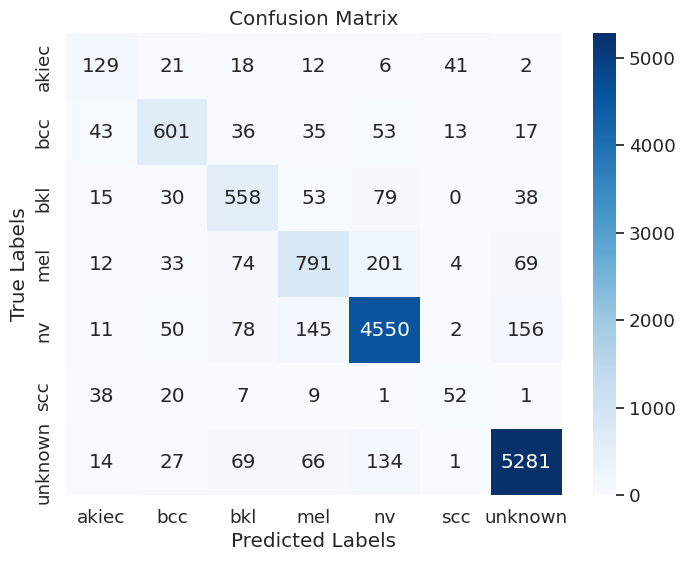


Overall Multiclass Testing Accuracy: 0.873393691588785
Classification Report:
              precision    recall  f1-score       support
akiec          0.492366  0.563319  0.525458    229.000000
bcc            0.768542  0.753133  0.760759    798.000000
bkl            0.664286  0.721863  0.691878    773.000000
mel            0.711971  0.668074  0.689325   1184.000000
nv             0.905653  0.911458  0.908546   4992.000000
scc            0.460177  0.406250  0.431535    128.000000
unknown        0.949137  0.944385  0.946755   5592.000000
accuracy       0.873394  0.873394  0.873394      0.873394
macro avg      0.707448  0.709783  0.707751  13696.000000
weighted avg   0.873979  0.873394  0.873492  13696.000000

Overall Multiclass ROC AUC Score: 0.8430929408510163


In [25]:
y_pred = model.predict(x_test)
print(y_pred)
y_pred_labels = np.argmax(y_pred, axis=1)

# Convert one-hot encoded actual classes to class labels
y_true_labels = np.argmax(y_test, axis=1)

# Convert class indices to class names for y_true and y_pred
y_true_labels_names = [label_to_dx_mapping[label] for label in y_true_labels]
y_pred_labels_names = [label_to_dx_mapping[label] for label in y_pred_labels]

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true_labels_names, y_pred_labels_names)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font scale
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=list(label_to_dx_mapping.values()),
            yticklabels=list(label_to_dx_mapping.values()))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Calculate accuracy
accuracy = np.mean(y_pred_labels == y_true_labels)
print("\nOverall Multiclass Testing Accuracy:", accuracy)
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import LabelBinarizer

# Calculate Precision, Recall, F1-score, and Support
report = classification_report(y_true_labels_names, y_pred_labels_names, output_dict=True)
report_df = pd.DataFrame(report).transpose()

# Calculate AUC score
# Binarize the output
lb = LabelBinarizer()
lb.fit(y_true_labels_names)
y_test_bin = lb.transform(y_true_labels_names)
y_pred_bin = lb.transform(y_pred_labels_names)

roc_auc = roc_auc_score(y_test_bin, y_pred_bin, multi_class='ovr')

print("Classification Report:")
print(report_df)

print("\nOverall Multiclass ROC AUC Score:", roc_auc)


428/428 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step


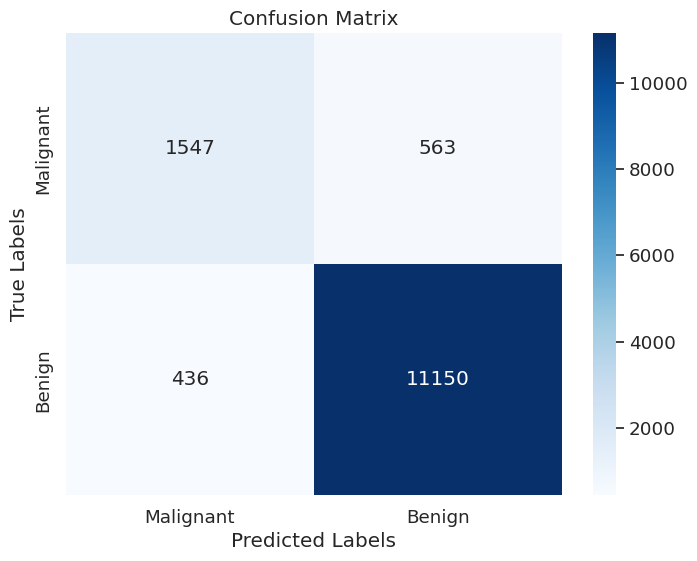


Overall Binary Class Testing Accuracy: 0.9270589953271028
Classification Report:
              precision    recall  f1-score       support
Malignant      0.780131  0.733175  0.755925   2110.000000
Benign         0.951934  0.962368  0.957123  11586.000000
accuracy       0.927059  0.927059  0.927059      0.927059
macro avg      0.866032  0.847772  0.856524  13696.000000
weighted avg   0.925466  0.927059  0.926126  13696.000000

Overall Binary Class ROC AUC Score: 0.847771865537996


In [26]:
# Predict probabilities
y_pred = model.predict(x_test)

# Convert y_pred to the new binary format
y_new = np.zeros((y_pred.shape[0], 2))  # Initialize a new array of shape (n, 2)
y_new[:, 0] = y_pred[:, 1] + y_pred[:, 3] + y_pred[:, 5]
y_new[:, 1] = y_pred[:, 0] + y_pred[:, 2] + y_pred[:, 4] + y_pred[:, 6]

# Convert probabilities to class labels
y_pred_labels = np.argmax(y_new, axis=1)
# Convert one-hot encoded y_test to the new binary format
y_true_new = np.zeros((y_test.shape[0], 2))  # Initialize a new array of shape (n, 2)
y_true_new[:, 0] = y_test[:, 1] + y_test[:, 3] + y_test[:, 5]
y_true_new[:, 1] = y_test[:, 0] + y_test[:, 2] + y_test[:, 4] + y_test[:, 6]

# Convert probabilities to class labels
y_true_labels = np.argmax(y_true_new, axis=1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font scale
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Malignant', 'Benign'],
            yticklabels=['Malignant', 'Benign'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Calculate accuracy
accuracy = np.mean(y_pred_labels == y_true_labels)
print("\nOverall Binary Class Testing Accuracy:", accuracy)
from sklearn.metrics import classification_report, roc_auc_score

# Calculate Precision, Recall, F1-score, and Support
report = classification_report(y_true_labels, y_pred_labels, target_names=['Malignant', 'Benign'], output_dict=True)
report_df = pd.DataFrame(report).transpose()

# Calculate AUC score
roc_auc = roc_auc_score(y_true_labels, y_pred_labels)

print("Classification Report:")
print(report_df)

print("\nOverall Binary Class ROC AUC Score:", roc_auc)
